In [2]:
pip install numpy mahotas scikit-image matplotlib

  Obtaining dependency information for mahotas from https://files.pythonhosted.org/packages/e0/0c/3710525e4d3a2cb28852cb77878d8268e3e56c52cdb4018972685a11e6cd/mahotas-1.4.18-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   -- ------------------------------------- 0.1/1.7 MB 2.2 MB/s eta 0:00:01
   ------------------------ --------------- 1.0/1.7 MB 11.0 MB/s eta 0:00:01
   ------------------------ --------------- 1.0/1.7 MB 11.0 MB/s eta 0:00:01
   ---------------------------------------- 1.7/1.7 MB 9.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


C:\Users\Avinash\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


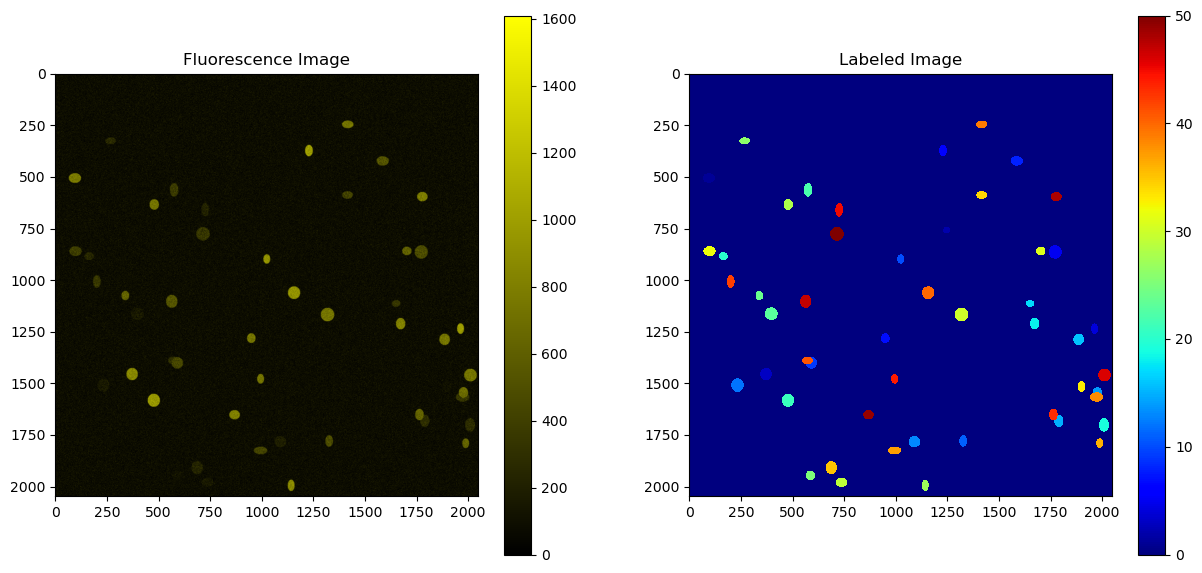

Number of objects detected: 50


In [3]:
import numpy as np
import mahotas as mh
from skimage.draw import disk
from skimage import filters, util
from skimage.filters import gaussian
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from skimage.draw import ellipse

def generate_realistic_cell(size, fluorescence_level):
    """
    Generates a single oval-shaped cell with random radii to simulate realistic yeast cells.
    """
    major_axis = size[0] * np.random.uniform(0.985, 0.99)  # Randomize the major axis
    minor_axis = size[1] * np.random.uniform(0.985, 0.99)  # Randomize the minor axis

    cell_image = np.zeros((int(major_axis*4), int(minor_axis*4)), dtype=np.uint16)
    rr, cc = ellipse(int(major_axis*2), int(minor_axis*2), int(major_axis*1.8), int(minor_axis*1.8), shape=cell_image.shape)
    cell_image[rr, cc] = fluorescence_level
    return cell_image


def place_realistic_cells(image_size, num_cells, cell_properties):
    fluorescence_image = np.zeros(image_size, dtype=np.uint16)
    labelled_image = np.zeros(image_size, dtype=np.uint8)
    label_index = 1

    for props in cell_properties:
        cell_image = generate_realistic_cell(props['size'], props['fluorescence_level'])
        cell_height, cell_width = cell_image.shape
        x = np.random.randint(0, image_size[1] - cell_width + 1)
        y = np.random.randint(0, image_size[0] - cell_height + 1)

        # Place the cell in the fluorescence image
        fluorescence_image[y:y + cell_height, x:x + cell_width] = np.maximum(fluorescence_image[y:y + cell_height, x:x + cell_width], cell_image)

        # Place the label in the labeled image (solid color)
        cell_mask = cell_image > 0
        labelled_image[y:y + cell_height, x:x + cell_width][cell_mask] = label_index
        label_index += 1

    # Apply Gaussian blur to simulate optical system blur
    fluorescence_image = gaussian(fluorescence_image, sigma=1)

    # Add reduced Gaussian noise for realism
    fluorescence_image = util.random_noise(fluorescence_image, mode='gaussian', var=0.00001)

    # Scale the image back to uint16 after adding noise
    fluorescence_image = np.clip(fluorescence_image * 65535, 0, 65535).astype(np.uint16)

    return fluorescence_image, labelled_image

# Custom colormap for fluorescence image (black to yellow)
cmap_fluorescence = mcolors.LinearSegmentedColormap.from_list('black_yellow', ['black', 'yellow'])

# Set image and cell properties for realistic yeast fluorescence images
image_size = (2048, 2048)
num_cells = 50
cell_properties = [{'size': (np.random.randint(10, 20), np.random.randint(10, 20)),
                    'fluorescence_level': np.random.randint(1000, )} for _ in range(num_cells)]

# Generate the fluorescence image and corresponding labeled image
fluorescence_image, labelled_image = place_realistic_cells(image_size, num_cells, cell_properties)

# Display the fluorescence image with the yellow colormap
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
cax1 = ax[0].imshow(fluorescence_image, cmap=cmap_fluorescence)
fig.colorbar(cax1, ax=ax[0], orientation='vertical')
ax[0].set_title('Fluorescence Image')

# Display the labeled image with a scale and black background
cax2 = ax[1].imshow(labelled_image, cmap=plt.cm.jet, interpolation='nearest')
fig.colorbar(cax2, ax=ax[1], orientation='vertical')
ax[1].set_title('Labeled Image')

plt.show()

print(f"Number of objects detected: {num_cells}")


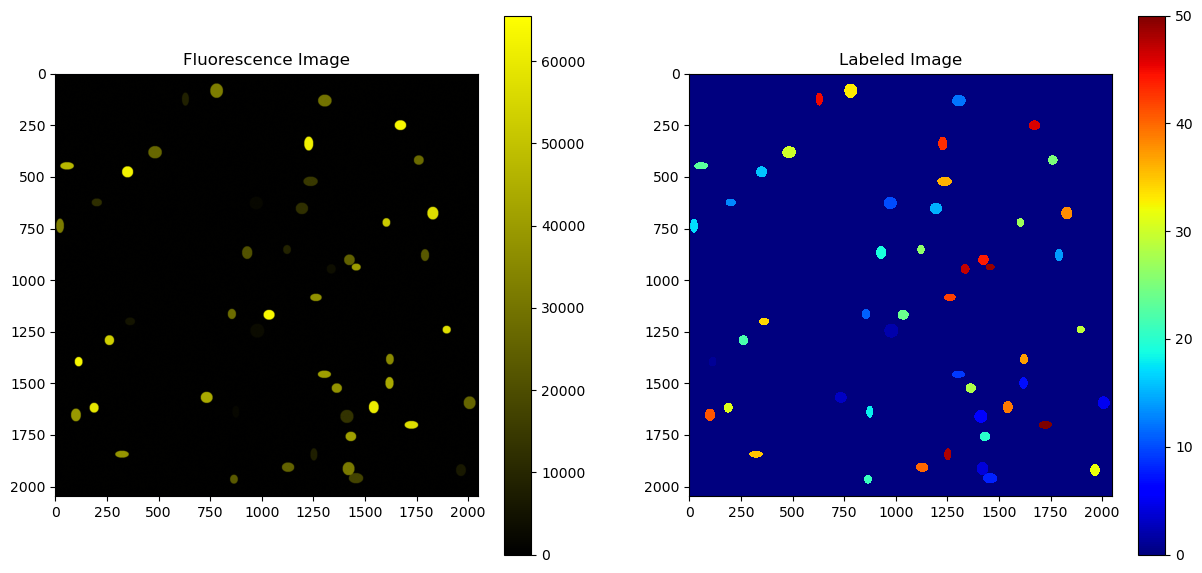

Number of objects detected: 50


In [10]:
import numpy as np
import mahotas as mh
from skimage.draw import ellipse
from skimage.filters import gaussian
from skimage import util
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def generate_realistic_cell(size, fluorescence_level):
    """
    Generates a single oval-shaped cell with random radii to simulate realistic yeast cells.
    """
    major_axis = size[0] * np.random.uniform(0.95, 1.05)  # Randomize the major axis with a bit more variability
    minor_axis = size[1] * np.random.uniform(0.95, 1.05)  # Randomize the minor axis with a bit more variability

    cell_image = np.zeros((int(major_axis*4), int(minor_axis*4)), dtype=np.uint16)
    rr, cc = ellipse(int(major_axis*2), int(minor_axis*2), int(major_axis*1.8), int(minor_axis*1.8), shape=cell_image.shape)
    cell_image[rr, cc] = fluorescence_level
    return cell_image

def place_realistic_cells(image_size, num_cells, cell_properties, max_overlap=0.2, sigma=1, noise_variance=0.0001):
    """
    Places cells on the image with controlled overlap, applies Gaussian blur, and adds noise.
    """
    fluorescence_image = np.zeros(image_size, dtype=np.uint16)
    labelled_image = np.zeros(image_size, dtype=np.uint8)
    label_index = 1

    for props in cell_properties:
        cell_image = generate_realistic_cell(props['size'], props['fluorescence_level'])
        cell_height, cell_width = cell_image.shape

        # Try placing the cell with controlled overlap
        for _ in range(100):  # Attempt to place the cell 100 times
            x = np.random.randint(0, image_size[1] - cell_width + 1)
            y = np.random.randint(0, image_size[0] - cell_height + 1)

            # Check overlap
            existing_overlap = np.sum((fluorescence_image[y:y + cell_height, x:x + cell_width] > 0) & (cell_image > 0))
            if existing_overlap / np.sum(cell_image > 0) <= max_overlap:
                break

        # Place the cell in the fluorescence image
        fluorescence_image[y:y + cell_height, x:x + cell_width] = np.maximum(fluorescence_image[y:y + cell_height, x:x + cell_width], cell_image)

        # Place the label in the labeled image (solid color)
        cell_mask = cell_image > 0
        labelled_image[y:y + cell_height, x:x + cell_width][cell_mask] = label_index
        label_index += 1

    # Apply Gaussian blur to simulate optical system blur
    fluorescence_image = gaussian(fluorescence_image, sigma=sigma)

    # Add reduced Gaussian noise for realism
    fluorescence_image = util.random_noise(fluorescence_image, mode='gaussian', var=noise_variance)

    # Scale the image back to uint16 after adding noise
    fluorescence_image = np.clip(fluorescence_image * 65535, 0, 65535).astype(np.uint16)

    return fluorescence_image, labelled_image

# Custom colormap for fluorescence image (black to yellow)
cmap_fluorescence = mcolors.LinearSegmentedColormap.from_list('black_yellow', ['black', 'yellow'])

# Set image and cell properties for realistic yeast fluorescence images
image_size = (2048, 2048)
num_cells = 50
cell_properties = [{'size': (np.random.randint(10, 20), np.random.randint(10, 20)),
                    'fluorescence_level': np.random.randint(1000, 65535)} for _ in range(num_cells)]

# Generate the fluorescence image and corresponding labeled image with added parameters
fluorescence_image, labelled_image = place_realistic_cells(image_size, num_cells, cell_properties, max_overlap=0.2, sigma=1, noise_variance=0.0001)

# Display the fluorescence image with the yellow colormap
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
cax1 = ax[0].imshow(fluorescence_image, cmap=cmap_fluorescence)
fig.colorbar(cax1, ax=ax[0], orientation='vertical')
ax[0].set_title('Fluorescence Image')

# Display the labeled image with a scale and black background
cax2 = ax[1].imshow(labelled_image, cmap=plt.cm.jet, interpolation='nearest')
fig.colorbar(cax2, ax=ax[1], orientation='vertical')
ax[1].set_title('Labeled Image')

plt.show()

print(f"Number of objects detected: {num_cells}")
